In [ ]:
#installing geopandas and rasterio packeges requierments
!pip install geopandas rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 KB 5.4 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.1.3 which is incompatible.


In [ ]:
#mount to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


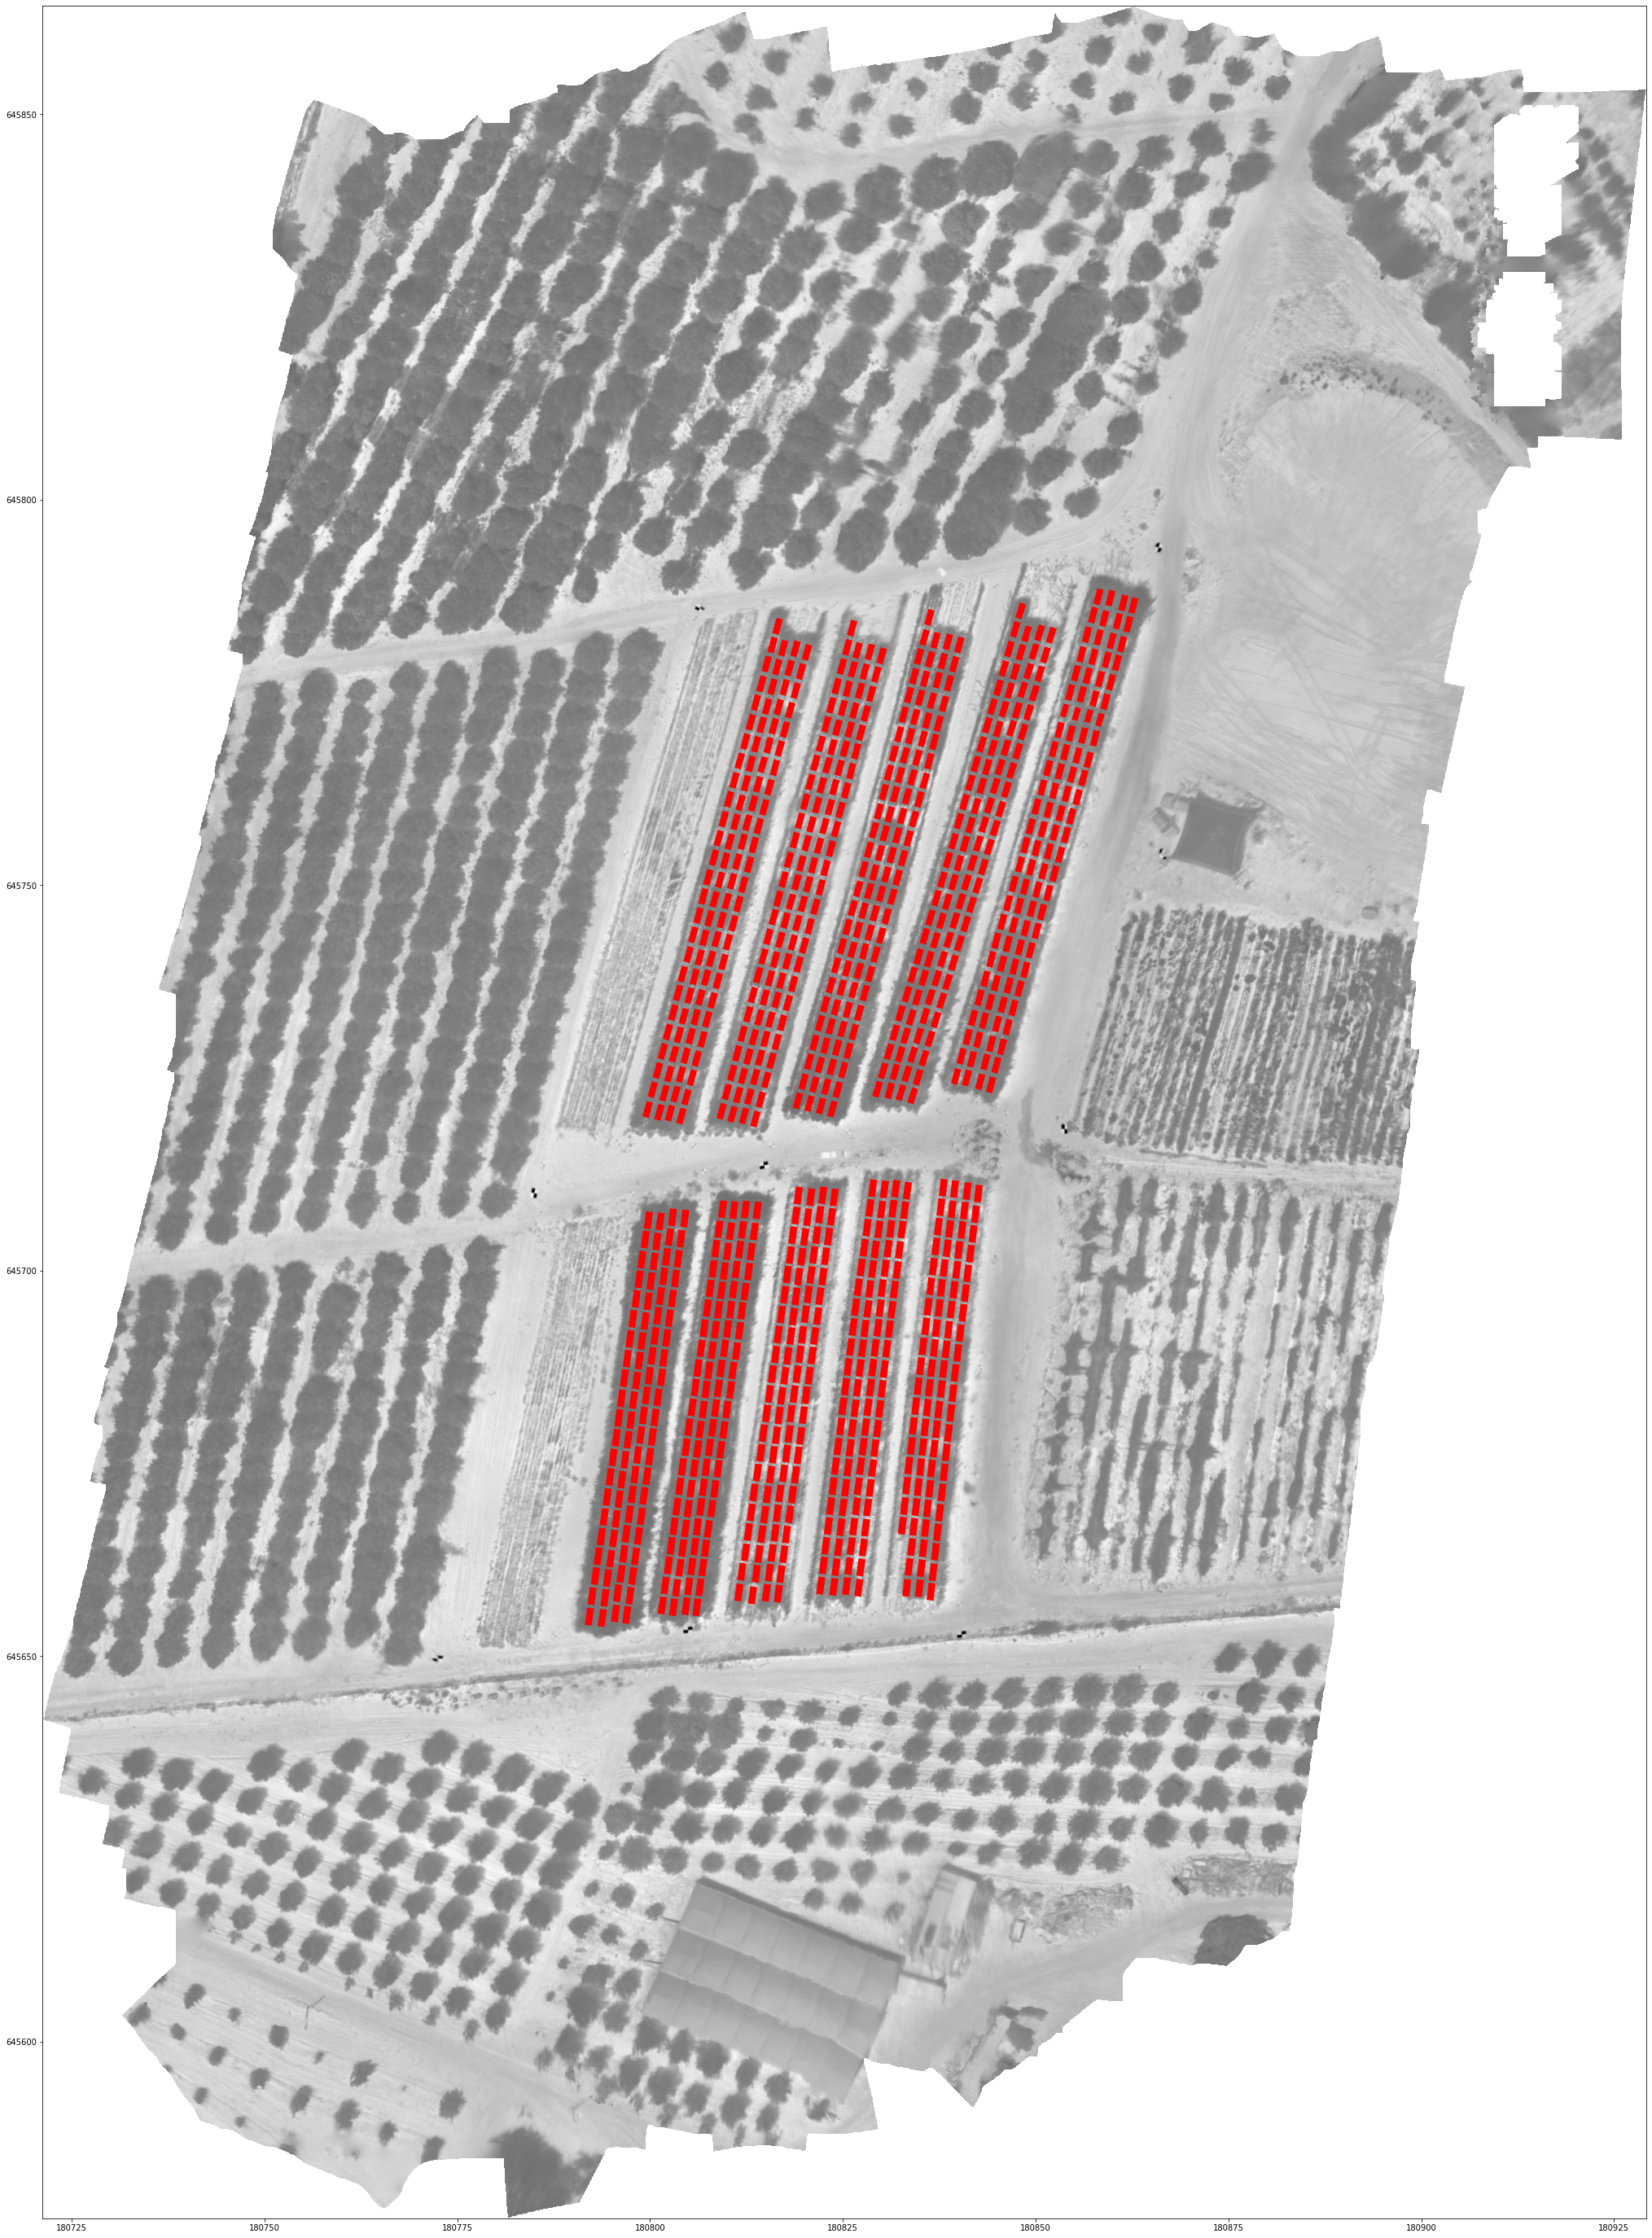

In [ ]:
#importing libreries
import geopandas
import pandas as pd
import rasterio
import rasterio.plot
import rasterio.mask
import matplotlib.pyplot as plt
import numpy as np
import sys
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import skimage.filters as f
#setting path as variable that holds the image path's from google drive
path = '/content/drive/MyDrive/sesame_polygons/tifs/Copy of Rehovot_2020-08-20_[WEST]_Agisoft.tif'
#setting shp as variable that holds the polygons file path's from google drive
shp='/content/drive/MyDrive/sesame_polygons/Sesame_K_polygons_27_1_22.shp'
# Read in the TIF image
image = rasterio.open(path)
# Read in the shapefile
shapefile = geopandas.read_file(shp)
# Get the SRS (Spatial reference system) of the shapefile
shapefile_srs = shapefile.crs

# Get the SRS of the image
image_srs = image.crs
# If the SRS of the shapefile and image are different, re-project the shapefile
if shapefile_srs != image_srs:
    shapefile = shapefile.to_crs(image_srs)
#Offset correction between the polygons and the image
shapefile = shapefile.translate(xoff=+6.5)
shapefile = shapefile.translate(yoff=+7)

#setting the figure size
fig, ax = plt.subplots(figsize=(50, 50))
# Plot the image
rasterio.plot.show(image,cmap='gray',ax=plt.gca())
# Plot the shapefile on top of the image
shapefile.plot(ax=plt.gca(), color='red')


# Display the plot
plt.show()

28.301 65.699
39.768745


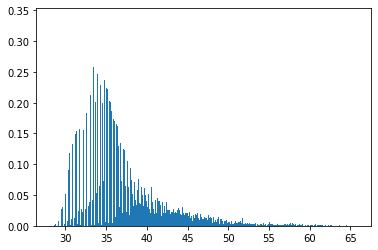

In [ ]:
#cropping out the image according to the shapefile geometry
with rasterio.open(path) as src:
  out_image, out_transform = rasterio.mask.mask(src, shapefile.geometry, crop=True)
#combining all the polygons data imto one array
arr=out_image.reshape(-1)
#mask the array - values which are negative changed to nan
mask = arr < 0
arr[mask] = np.nan
#the nan values got droped using pandas dataframe
df = pd.DataFrame(arr)
df = df.dropna()
arr=np.array(df)
#round the values in the array into 3 digits after the decimal point
arr=np.round(arr,3)
#thresholding using otsu to determine the border tempreture between plantes and soil
t = f.threshold_otsu(arr)
#plot the tempreture distribution
plt.hist(arr, density=True,bins=10000)
#printing the min temp max temp and the threshold temp
print(arr.min(),arr.max())
print(t)

In [ ]:
# Read in the shapefile
data_df= geopandas.read_file(shp)
#using only the polygons serial number
data_df=data_df[['ORIG_FID']]
#readind the data from this 2 csvs and match them with the polygon serial number
genotype=pd.read_csv('/content/drive/MyDrive/sesame_polygons/Field map seasame K.csv')
yieldd=pd.read_csv('/content/drive/MyDrive/sesame_polygons/SYPP_BLUE_2020.csv')
data_df['genotyp'] = genotype['Genotype']
data_df['Block'] = genotype['Block']
data_df['yield'] = ''
data_df['median_temp'] = ''
l=len(data_df)
for i in range (0,l):
  value = data_df.iat[i,1]
  rows, cols = np.where(yieldd == value)
  rows=int(rows)
  data_df.iat[i,3]=yieldd.iat[rows,1]
#masking each polygon according to the min temp and the otsu threshold temp.
#the temps that out of rang changed to nan and the median calculated by ignoring the nan values
for i in range (0,925):
  array=out_image[:,:,i]
  mask = array < arr.min()
  array[mask] = np.nan
  mask = array > t
  array[mask] = np.nan
  data_df.iat[i,4]=np.nanmedian(array)

/usr/local/lib/python3.8/dist-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


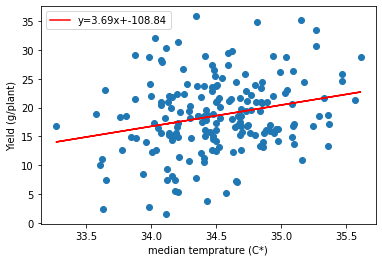

0.0604205791765039


In [ ]:
#for each genotype we have 5 replicates (5 blocks). we clculated the mean of the median of this 5 polygons
arra=np.array(data_df.groupby('genotyp')['median_temp'].mean())
data_df=data_df.iloc[0:185].sort_values(by='genotyp')
#plotting a scatter plot. y axes - g/plant, x-axes temprature
plt.scatter(arra, np.array(data_df.iloc[0:185,3]))
plt.xlabel('median temprature (C*)')
plt.ylabel('Yield (g/plant)')
#plotting linear regression
reg = LinearRegression().fit(arra.reshape(-1, 1), np.array(data_df.iloc[0:185,3]))
y_pred = reg.predict(arra.reshape(-1, 1))
plt.plot(arra, y_pred, 'r', label='y={:.2f}x+{:.2f}'.format(reg.coef_[0],reg.intercept_))
plt.legend(loc="best")
#calculating r^2 coefficient
r2 = r2_score(np.array(data_df.iloc[0:185,3]), y_pred)
plt.show()
print(r2)